# Linear Factor Models #

**Performance Measurement**

Risk_Factors.xlsx contains monthly observations of the risk-free rate and the three Fama–French risk factors (expressed as percentages, but without "%"), over the ten-year period from Jan 2004 through Dec 2013.

Using excess returns for the ten industry portfolios, calculate the following performance metrics:

* Sharpe ratio
* Sortino ratio (using risk-free rate as target)
* Treynor ratio (using CAPM β)
* Jensen's α
* Three-factor α

The sample semi-variance can be estimated as:
$$
\frac{1}{T}\sum_{t=1}^T min(R_{it} - R_{ft} , 0)^2
$$
where Ri is return on industry portfolio and Rf is risk-free rate.
* Create a table showing the performance metrics for the ten industry portfolios.
* Plot your results as a bar chart for each performance metric.
* Briefly explain the economic significance of each of the three performance ratios (but not α's).

Economic significance:

* Sharpe ratio represents risk premium per unit of total risk:
    * Includes idiosyncratic risk, which penalises individual investments and non-diversified portfolios.
    * Hence not appropriate for comparing performance of individual investment to diversified portfolio
    * Implicitly assumes normal returns, so cannot distinguish between asymmetric return distributions with same variance but different skewness
* Sortino ratio represents risk premium per unit of downside risk, which can distinguish between asymmetric return distributions with same variance but different skewness
* Treynor ratio represents risk premium per unit of market risk, which ignores idiosyncratic risk as well as other types of systematic risk
* Information ratio (or appraisal ratio) is expected deviation
from target (or benchmark) return, per unit of tracking error. Measures ability of fund manager to exceed target return,
relative to amount of tracking error
* Three-factor α : Scroll Down for information on Fama-French 3 Factor model and possible Carhart 4 Factor model. The $\alpha$ for three-factor is offset of model (refer to CAPM)

FORMULA
$$
Sharpe_{i} = \frac{E(\bar{R_i} - R_f)}{\sqrt{Var(\bar{R_i} - R_f)}}
$$
$$
Treynor_{i} = \frac{E(\bar{R_i} - R_f)}{{\beta}_i}
$$
$$
JensenAlpha_{i} = E(\bar{R_i} - R_f) -{\beta}_i E(\bar{R_m} - R_f)
$$
$$
InformationRatio_{i} = \frac{E(\bar{R_i} - R_t)}{\sqrt{Var(\bar{R_i} - R_t)}}
$$
$$
Sortino_{i} = \frac{E(\bar{R_i} - \bar{R_t})}{\sqrt{SemiVar(\bar{R_i},\bar{R_t})}}
$$

In [1]:
import numpy as np

import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt

import matplotlib.ticker as ticker
from sklearn import linear_model

# import statsmodels.api as sm

In [2]:
# load data
industry_portfolio_df = pd.read_excel("Industry_Portfolios.xlsx")
market_portfolio_df = pd.read_excel("Market_Portfolio.xlsx")
risk_factors_df = pd.read_excel("Risk_Factors.xlsx")

c:\Users\kilo\anaconda3\Lib\site-packages\openpyxl\worksheet\_read_only.py:79: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():
c:\Users\kilo\anaconda3\Lib\site-packages\openpyxl\worksheet\_read_only.py:79: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():
c:\Users\kilo\anaconda3\Lib\site-packages\openpyxl\worksheet\_read_only.py:79: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


In [3]:
# use merge for join inner i guess
concated_df = industry_portfolio_df.merge(market_portfolio_df, on="Date", how="inner")
concated_df = concated_df.merge(risk_factors_df, on="Date", how="inner")
portfolio_cols = concated_df.columns[1:12]
concated_df.head()

,Date,NoDur,Durbl,Manuf,Enrgy,HiTec,Telcm,Shops,Hlth,Utils,Other,Market,Rf,Rm-Rf,SMB,HML
0,200401,0.06,-1.07,-0.62,0.44,4.53,1.41,0.45,3.09,1.92,2.88,2.22,0.07,2.15,2.67,1.55
1,200402,4.25,-0.07,1.95,4.69,-2.92,-0.52,6.09,0.89,2.07,2.16,1.46,0.06,1.40,-1.17,0.45
2,200403,-0.09,-1.15,-0.27,-0.13,-2.55,-2.07,0.29,-3.96,1.13,-0.63,-1.23,0.09,-1.32,1.84,0.07
3,200404,1.42,2.30,-0.17,2.52,-4.91,-0.48,-2.70,3.54,-3.55,-3.76,-1.75,0.08,-1.83,-2.59,-1.67
4,200405,-1.89,-1.64,1.61,0.39,4.85,-2.95,0.30,-0.42,1.28,1.86,1.23,0.06,1.17,-0.10,-0.33


In [4]:
excess_risk_df = pd.DataFrame()
for x in portfolio_cols:
    excess_risk_df[f"{x}_excess"] = concated_df[x] - concated_df["Rf"]
excess_risk_df.head()

,NoDur_excess,Durbl_excess,Manuf_excess,Enrgy_excess,HiTec_excess,Telcm_excess,Shops_excess,Hlth_excess,Utils_excess,Other_excess,Market_excess
0,-0.01,-1.14,-0.69,0.37,4.46,1.34,0.38,3.02,1.85,2.81,2.15
1,4.19,-0.13,1.89,4.63,-2.98,-0.58,6.03,0.83,2.01,2.10,1.40
2,-0.18,-1.24,-0.36,-0.22,-2.64,-2.16,0.20,-4.05,1.04,-0.72,-1.32
3,1.34,2.22,-0.25,2.44,-4.99,-0.56,-2.78,3.46,-3.63,-3.84,-1.83
4,-1.95,-1.70,1.55,0.33,4.79,-3.01,0.24,-0.48,1.22,1.80,1.17


In [5]:
excess_cols = excess_risk_df.columns

In [6]:
concated_df = pd.concat([concated_df, excess_risk_df], axis=1)

## Sharpe Ratio ##

In [7]:
sharpe = excess_risk_df.mean().to_numpy() / np.sqrt(excess_risk_df.var().to_numpy())

## Treynor Ratio ##

In [8]:
# regression for market model
# use this to get intercept and slope
market_model_result = []
x = excess_risk_df["Market_excess"].to_numpy()
for portfolio in excess_cols:
    # print(portfolio)
    y = excess_risk_df[portfolio].to_numpy()
    market_model_result.append(np.polyfit(x, y, 1)[::-1])
market_model_result_intercept = []
market_model_result_slope = []
for x in market_model_result:
    market_model_result_intercept.append(x[0])
    market_model_result_slope.append(x[1])
market_model_result_intercept = np.array(market_model_result_intercept)
market_model_result_slope = np.array(market_model_result_slope)

# actual calculation
treynor = excess_risk_df.mean().to_numpy() / market_model_result_slope

## Jensen Alpha ##

In [9]:
jensen_alpha = (
    excess_risk_df.mean().to_numpy()
    - excess_risk_df["Market_excess"].mean() * market_model_result_slope
)

## Sortino Ratio ##

In [10]:
# remove excess return > 0, replace with 0
downside_df = excess_risk_df.mask(excess_risk_df > 0, 0, inplace=False)
# this is effectively the formula provided
semivariance = (downside_df**2).mean()
sortino = excess_risk_df.mean().to_numpy() / np.sqrt(semivariance).to_numpy()

## Information Ratio - Possible Expansion for Exam ##

Assume a monthly target return $R_t = 1 \%$ 

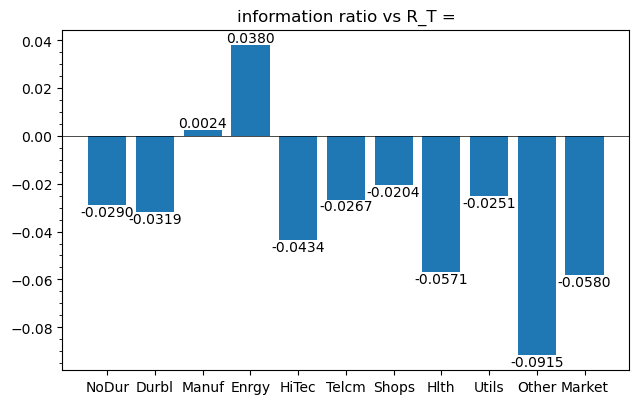

In [11]:
rt = 1
target_excess_df = pd.DataFrame()
for x in portfolio_cols:
    target_excess_df[f"{x}_excess"] = concated_df[x] - rt
# target_excess_df.head()
information = target_excess_df.mean().to_numpy() / np.sqrt(
    target_excess_df.var().to_numpy()
)

# tidy up result
information_result_df = pd.DataFrame([portfolio_cols, information]).T
information_result_df.set_axis(["industries", "information_ratio vs 1%"], axis=1)

# plot bar
fig, ax = plt.subplots(1)
fig.set_figheight(4)
fig.tight_layout()
bars = ax.bar(information_result_df[0], information_result_df[1])
ax.bar_label(bars, fmt="%.4f")
ax.axhline(0, lw=0.5, color="black")
ax.set_title("information ratio vs R_T =")
ax.yaxis.set_major_locator(ticker.AutoLocator())
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())

## 3 Factor Alpha ##
Eugene Fama and Kenneth French use three-factor model with risk factors for market risk, size risk, and value risk:
$$
\tilde{R_i} - R_f = \alpha _i + \beta _i (\tilde{R_m} - R_f) + \gamma _i (\tilde{R_s} - \tilde{R_b}) + \delta _i (\tilde{R_h} - \tilde{R_l}) + \tilde{\epsilon} _i
$$

* Risk factor for size risk (“SMB”) is return on portfolio that is
long on small-cap stocks and short on big-cap stocks
* Risk factor for value risk (“HML”) is return on portfolio that
is long on value stocks and short on growth stocks
* Positive (or negative) coefficient for SMB means that
portfolio behaves like small-cap (or big-cap) stock
* Positive (or negative) coefficient for HML means that
portfolio behaves like value (or growth) stock
* Provides motivation for Morningstar’s “style box”


In [12]:
# regression for three factor alpha, this is from Risk_Factors.xlsx
market_factor = concated_df["Rm-Rf"]
size_factor = concated_df["SMB"]
value_factor = concated_df["HML"]
x = pd.concat([market_factor, size_factor, value_factor], axis=1)
x.head()

,Rm-Rf,SMB,HML
0,2.15,2.67,1.55
1,1.40,-1.17,0.45
2,-1.32,1.84,0.07
3,-1.83,-2.59,-1.67
4,1.17,-0.10,-0.33


In [13]:
three_factor_alpha = []
# 3 variable linear regression !
for port in excess_risk_df.columns:
    regr = linear_model.LinearRegression()
    y = excess_risk_df[port]
    regr.fit(x, y)
    three_factor_alpha.append(regr.intercept_)
three_factor_alpha = np.array(three_factor_alpha)
three_factor_alpha

array([ 3.86704486e-01, -4.74341829e-01,  1.53284594e-01,  5.23006987e-01,
       -6.59794239e-02,  2.00724023e-01,  2.55941067e-01,  2.57472322e-01,
        4.74410582e-01, -4.04411529e-01, -2.22044605e-16])

## Carhart 4-Factor Model - Possible expansion for exam
##
* Mark Carhart augmented Fama–French three-factor model
with additional risk factor for momentum effect

$$
\tilde{R_i} - R_f = \alpha _i + \beta _i (\tilde{R_m} - R_f) + \gamma _i (\tilde{R_s} - \tilde{R_b}) + \delta _i (\tilde{R_h} - \tilde{R_l}) + \delta _i (\tilde{R_u} - \tilde{R_d}) \tilde{\epsilon} _i
$$

* Risk factor for momentum effect (“UMD”) is return on
portfolio that is long on past winners and short on past losers
* “Momentum effect” in short-term stock returns, over three-
to six-month investment horizon
* Past winners will usually continue to outperform, while past
losers will usually continue to underperform
* Fund managers often load up on momentum effect by buying
past winners and selling past losers, either as deliberate
investment strategy, or by coincidence
* “Reversal effect” (or “mean-reversion”) in long-term stock
returns, over three- to five-year investment horizon
* Past winners will usually underperform, while past losers will
usually outperform


In [14]:
result = pd.DataFrame([sharpe, sortino, treynor, jensen_alpha, three_factor_alpha]).T
result = pd.concat([pd.DataFrame(portfolio_cols), result], axis=1)
result.set_axis(
    ["industry", "sharpe", "sortino", "treynor", "jensen_alpha", "three_factor_alpha"],
    axis="columns",
    inplace=True,
)
result = result[0:10]
result

C:\Users\kilo\AppData\Local\Temp\ipykernel_4108\4130082633.py:3: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  result.set_axis(


,industry,sharpe,sortino,treynor,jensen_alpha,three_factor_alpha
0,NoDur,0.231099,0.350804,1.186372,0.369717,0.386704
1,Durbl,0.072356,0.111967,0.367463,-0.417903,-0.474342
2,Manuf,0.166616,0.241260,0.758251,0.160494,0.153285
3,Enrgy,0.181708,0.273612,1.143330,0.504485,0.523007
4,HiTec,0.118552,0.170620,0.564295,-0.064024,-0.065979
5,Telcm,0.169064,0.244940,0.836363,0.194348,0.200724
6,Shops,0.191753,0.293032,0.951258,0.274093,0.255941
7,Hlth,0.172529,0.270294,0.971435,0.236968,0.257472
8,Utils,0.210948,0.290044,1.452334,0.446523,0.474411
9,Other,0.064693,0.087351,0.299781,-0.387508,-0.404412


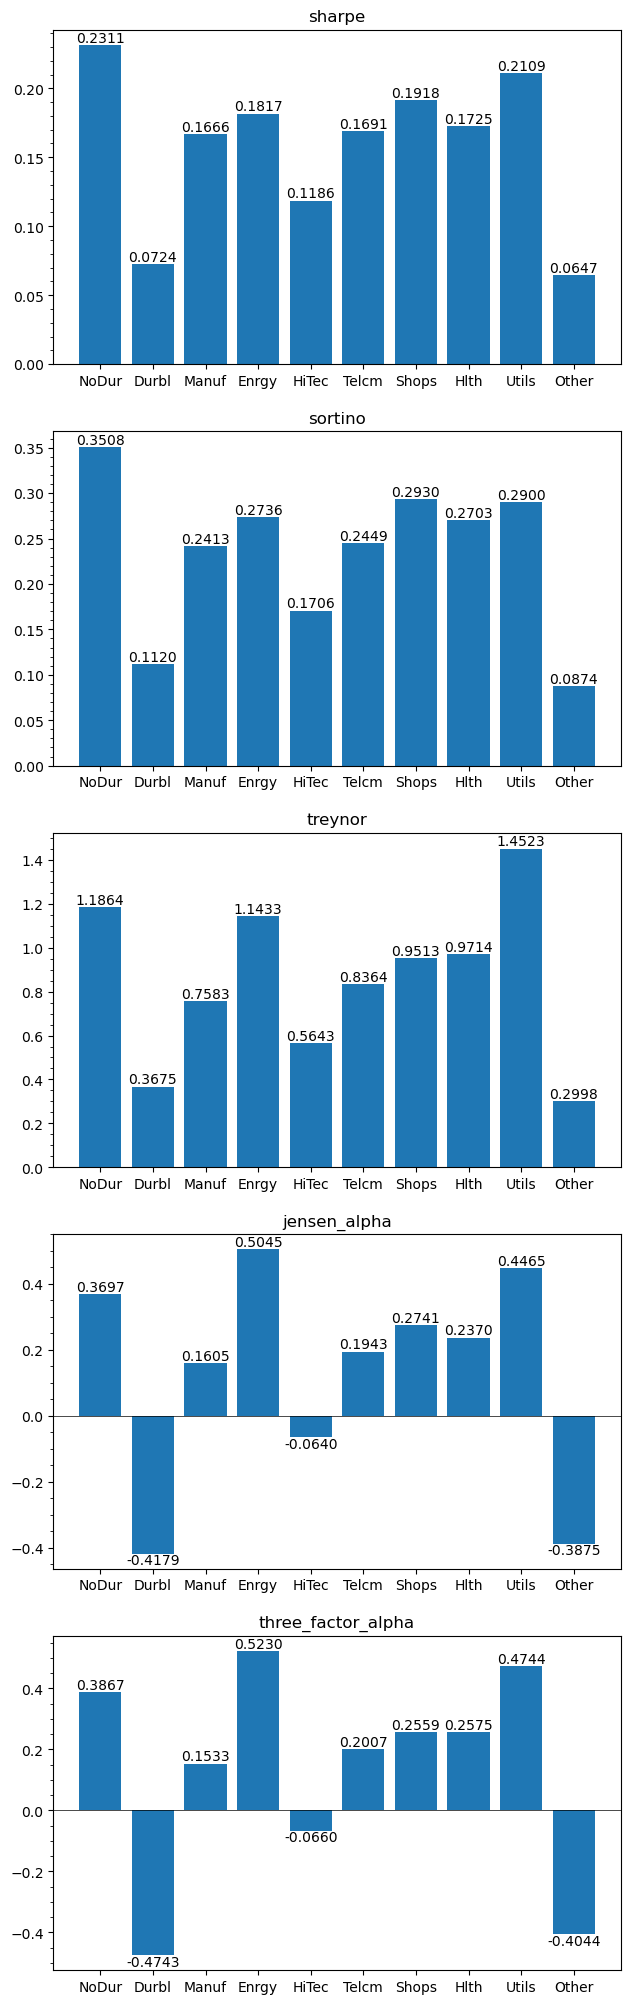

In [15]:
industries = result["industry"]
cols = result.columns
cols = cols[1:]
# sharpe = result.iloc[:, 1]

fig, ax = plt.subplots(len(cols), 1)
fig.set_figheight(len(cols) * 4)
fig.tight_layout()
fig.subplots_adjust(hspace=0.2)
for i, x in enumerate(cols):
    bars = ax[i].bar(industries, result.iloc[:, 1 + i])
    ax[i].bar_label(bars, fmt="%.4f")
    ax[i].axhline(0, lw=0.5, color="black")
    ax[i].set_title(x)
    ax[i].yaxis.set_major_locator(ticker.AutoLocator())
    ax[i].yaxis.set_minor_locator(ticker.AutoMinorLocator())
fig.savefig("risk_factors.jpeg")